In [1]:
import time
start_time = time.time()

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [3]:
# Install necessary packages
!pip install kagglehub -q
!pip install imutils -q
!pip install tensorflow -q

In [4]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from imutils import paths

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [5]:
# Download Datasets and Get Paths
print("Downloading datasets...")
# Path for the training dataset
damage_dataset_path = kagglehub.dataset_download("anujms/car-damage-detection")
print(f"Damage dataset downloaded to: {damage_dataset_path}")

# Path for an example prediction image
coco_dataset_path = kagglehub.dataset_download("lplenka/coco-car-damage-detection-dataset")
print(f"COCO dataset downloaded to: {coco_dataset_path}")

Damage dataset downloaded to: /kaggle/input/car-damage-detection
COCO dataset downloaded to: /kaggle/input/coco-car-damage-detection-dataset


In [6]:
# Configuration
INIT_LR = 1e-4
HEAD_EPOCHS = 20
FINE_TUNE_EPOCHS = 80
TOTAL_EPOCHS = HEAD_EPOCHS + FINE_TUNE_EPOCHS
BS = 64
CATEGORIES = ["00-damage", "01-whole"]

# Correctly Define Directories using the downloaded path
DIRECTORY_TRAIN = os.path.join(damage_dataset_path, "data1a", "training")
DIRECTORY_VAL = os.path.join(damage_dataset_path, "data1a", "validation")

# Load Data
print("Loading images...")
data = []
labels = []

# Function to load images from a directory
def load_images_from_dir(directory):
    for category in CATEGORIES:
        path = os.path.join(directory, category)
        if not os.path.exists(path):
            print(f"Directory not found: {path}. Skipping.")
            continue
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            data.append(image)
            labels.append(category)

# Load training and validation images
load_images_from_dir(DIRECTORY_TRAIN)
load_images_from_dir(DIRECTORY_VAL)


# Preprocess Labels and Data
print("Preprocessing data...")
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Split Data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                 test_size=0.20, stratify=labels, random_state=42)

print(f"Training samples: {len(trainX)}, Testing samples: {len(testX)}")

# Data Augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Loading images...
Preprocessing data...
Training samples: 1840, Testing samples: 460


In [7]:
# Build Model
print("Initializing InceptionV3 model...")
baseModel = InceptionV3(weights="imagenet", include_top=False,
                       input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Place the head FC model on top of the base model(Inceptionv3)
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze all layers in the base model
for layer in baseModel.layers:
    layer.trainable = False

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10, # Stop if val_accuracy doesn't improve for 10 epochs
    verbose=1,
    restore_best_weights=True
)

Initializing InceptionV3 model...


In [8]:
# Phase 1: Train the Head
print("Compiling and training head layers...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

H1 = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    epochs=HEAD_EPOCHS,
    callbacks=[early_stopping]
)

# Phase 2: Fine-Tuning
print("\nUnfreezing top layers for fine-tuning...")

# Unfreeze the top layers of the model
for layer in baseModel.layers[-50:]:
    layer.trainable = True

# Re-compile the model for fine-tuning with a lower learning rate
opt = Adam(learning_rate=INIT_LR / 10) # Use a 10x smaller learning rate
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print(" Starting fine-tuning phase...")
# We check if the first training phase completed all epochs or stopped early
initial_epoch = H1.epoch[-1] + 1
if initial_epoch < HEAD_EPOCHS:
    print(f"Early stopping occurred. Starting fine-tuning from epoch {initial_epoch}.")

H2 = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    epochs=TOTAL_EPOCHS,
    initial_epoch=initial_epoch, # Continue from where we left off
    callbacks=[early_stopping]
)

Compiling and training head layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


29/29 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5914 - loss: 0.9769 - val_accuracy: 0.7783 - val_loss: 0.4488
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 752ms/step - accuracy: 0.7884 - loss: 0.4849 - val_accuracy: 0.8587 - val_loss: 0.3436
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 773ms/step - accuracy: 0.8152 - loss: 0.4442 - val_accuracy: 0.8587 - val_loss: 0.3287
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 763ms/step - accuracy: 0.8390 - loss: 0.3958 - val_accuracy: 0.8022 - val_loss: 0.3890
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 723ms/step - accuracy: 0.8315 - loss: 0.3799 - val_accuracy: 0.8848 - val_loss: 0.2826
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 769ms/step - accuracy: 0.8109 - loss: 0.4042 - val_accuracy: 0.9000 - val_loss: 0.2660
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 746ms/step - accuracy: 0.8513 - loss: 0.3432 - val_accuracy: 0.8913 - val_loss: 0.2637
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 761ms/step - accuracy: 0.8588 - loss: 0.3432 - val_accuracy: 0.8935 -

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 983ms/step

Overall Accuracy: 91.74%
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   00-damage       0.95      0.88      0.91       230
    01-whole       0.89      0.95      0.92       230

    accuracy                           0.92       460
   macro avg       0.92      0.92      0.92       460
weighted avg       0.92      0.92      0.92       460

------------------------------------------------------------


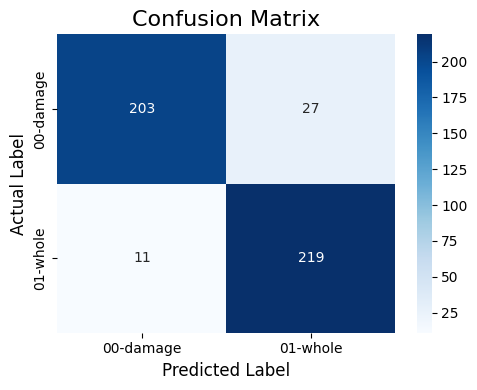

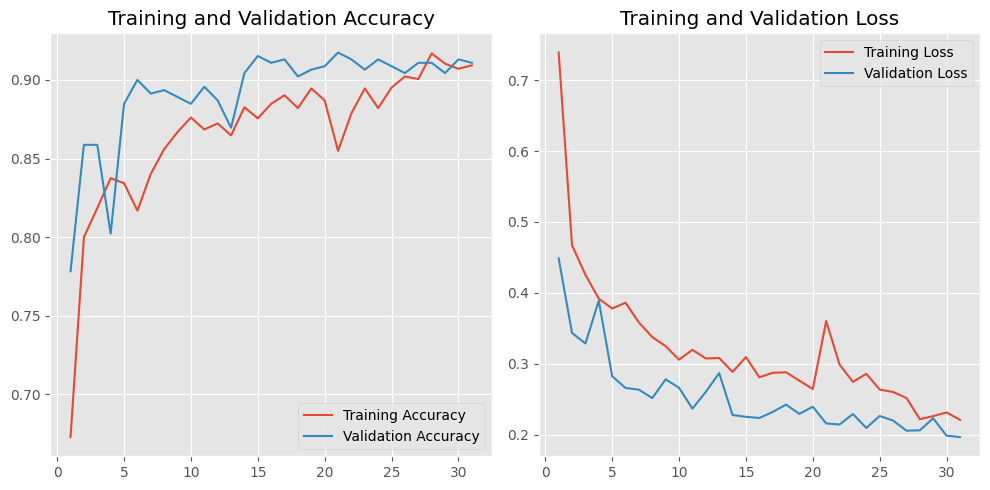


Model saved as car_damage_classifier.h5


In [9]:
# Evaluate Network
predictions = model.predict(testX, batch_size=BS)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(testY, axis=1)

# Calculate and Print Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")
print("-" * 60) # Separator line

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print("-" * 60) # Separator line

# Plot Confusion Matrix as a Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


# Plot Training History
history_dict = H1.history
if 'H2' in locals():
    for key in H1.history.keys():
        history_dict[key].extend(H2.history[key])

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.tight_layout()
plt.show()


# Save the Model
model.save('car_damage_classifier.h5')
print("\nModel saved as car_damage_classifier.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


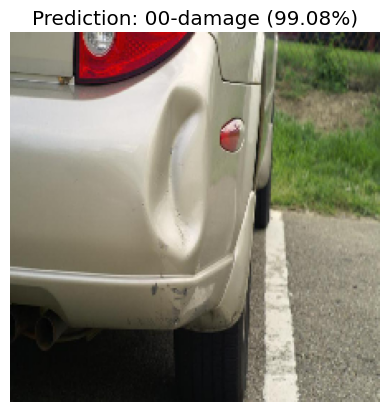

In [10]:
# Prediction Function
def predict_damage(image_path):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image_arr = img_to_array(image)
    image_arr = np.expand_dims(image_arr, axis=0)
    image_arr = preprocess_input(image_arr)

    # Make prediction
    prediction = model.predict(image_arr)
    class_index = np.argmax(prediction)
    label = lb.classes_[class_index]
    confidence = prediction[0][class_index] * 100

    # Display the image and result
    plt.imshow(image)
    plt.title(f"Prediction: {label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return label, confidence

# Use the prediction function
example_image_path = os.path.join(coco_dataset_path, "img", "1.jpg")
if os.path.exists(example_image_path):
    predict_damage(example_image_path)
else:
    print(f"Example image not found at: {example_image_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


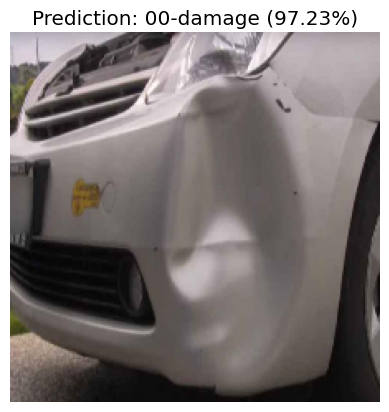

(np.str_('00-damage'), np.float32(97.22979))

In [11]:
predict_damage(os.path.join(coco_dataset_path, "train", "4.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


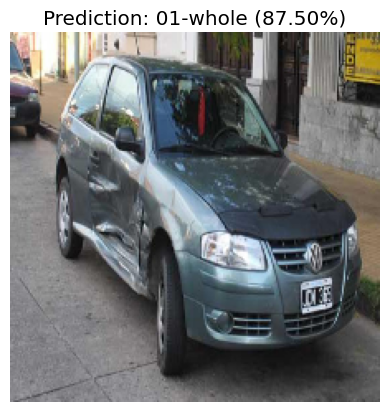

(np.str_('01-whole'), np.float32(87.50397))

In [12]:
predict_damage(os.path.join(coco_dataset_path, "test", "28.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


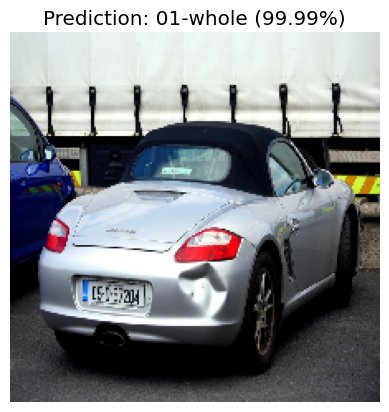

(np.str_('01-whole'), np.float32(99.994194))

In [13]:
predict_damage(os.path.join(coco_dataset_path, "img", "69.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


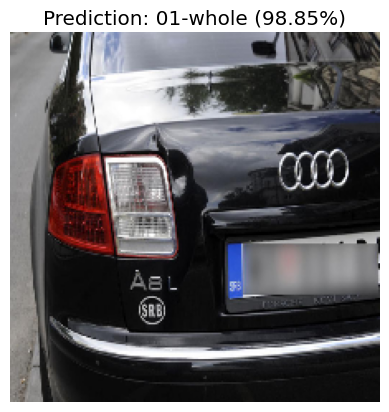

(np.str_('01-whole'), np.float32(98.84975))

In [14]:
predict_damage(os.path.join(coco_dataset_path, "train", "37.jpg"))

In [15]:
end_time = time.time()
runtime = end_time - start_time
print(f"Program executed in {runtime:.4f} seconds")
print(f"Program executed in {runtime/60:.4f} minutes")

Program executed in 885.6931 seconds
Program executed in 14.7616 minutes
